In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
data = pd.read_csv('./uci-secom.csv')

print(data.shape)

(1567, 592)


In [3]:
data.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [4]:
# 결측값 0으로 대체
data = data.replace(np.NaN, 0)
data.isnull().any().any()

False

In [5]:
# 데이터 시각화
unique_vals = data['Pass/Fail'].unique()
targets = [data.loc[data['Pass/Fail'] == val] for val in unique_vals]

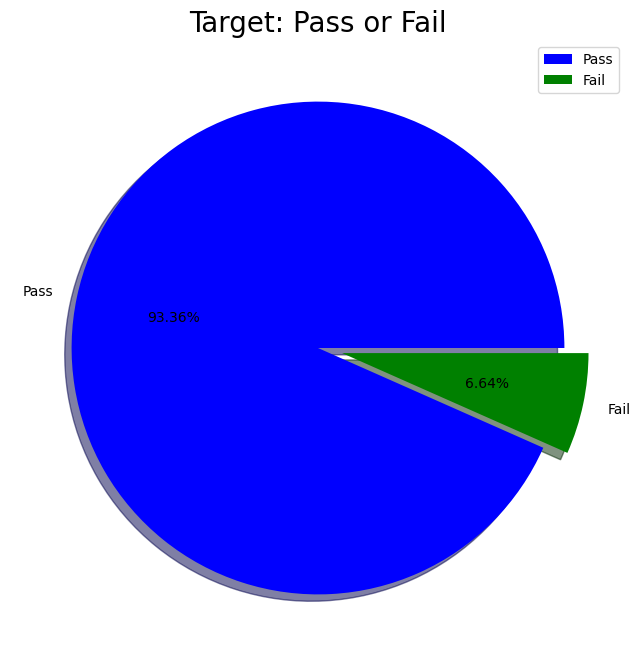

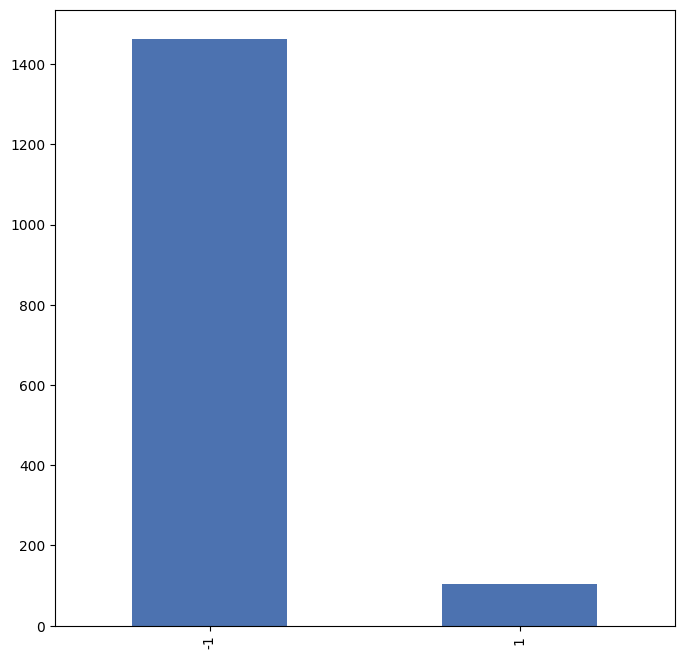

In [6]:
# 양품, 불량품 수치 확인
labels = ['Pass', 'Fail']
size = data['Pass/Fail'].value_counts()
colors = ['blue', 'green']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()
data['Pass/Fail'].value_counts().plot(kind="bar");

In [7]:
# 데이터 전처리

# 상관계수 계산
def remove_collinear_features(x, threshold):
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []
    
    # 상관계수 계산 반복
    for i in  iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # 상관계수가 임계값을 초과하는 경우
            if val >= threshold:
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])
                
    drops = set(drop_cols)
    x = x.drop(columns=drops)
    
    return x

In [8]:
# 상관관계가 높은 column 제거(70% 이상)
data = remove_collinear_features(data, 0.70)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_7552\2296898944.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = x.corr()


5 | 2 | 0.99
6 | 2 | 0.82
6 | 5 | 0.84
7 | 2 | 0.75
7 | 5 | 0.77
12 | 11 | 0.83
17 | 11 | 0.81
18 | 11 | 0.72
18 | 12 | 0.79
18 | 17 | 0.9
22 | 21 | 0.75
26 | 25 | 0.83
27 | 25 | 0.98
27 | 26 | 0.79
30 | 29 | 0.86
34 | 32 | 0.88
35 | 34 | 0.83
37 | 32 | 0.75
37 | 34 | 0.75
38 | 32 | 0.72
38 | 34 | 0.72
38 | 36 | 0.71
38 | 37 | 0.97
39 | 32 | 0.81
39 | 34 | 0.91
39 | 35 | 0.71
39 | 37 | 0.86
39 | 38 | 0.84
43 | 42 | 0.82
44 | 42 | 0.82
46 | 42 | 0.84
46 | 43 | 0.84
46 | 45 | 0.74
48 | 44 | 0.77
49 | 42 | 1.0
49 | 43 | 0.82
49 | 44 | 0.82
49 | 46 | 0.84
50 | 42 | 0.88
50 | 43 | 0.9
50 | 46 | 0.97
50 | 49 | 0.88
51 | 47 | 0.71
54 | 53 | 1.0
55 | 53 | 0.95
55 | 54 | 0.95
56 | 53 | 0.98
56 | 54 | 0.97
56 | 55 | 0.96
57 | 53 | 0.97
57 | 54 | 0.96
57 | 55 | 0.98
57 | 56 | 0.99
58 | 53 | 0.93
58 | 54 | 0.93
58 | 55 | 0.92
58 | 56 | 0.96
58 | 57 | 0.94
61 | 60 | 0.88
65 | 64 | 0.85
66 | 60 | 0.97
66 | 61 | 0.84
66 | 62 | 0.75
68 | 60 | 0.85
68 | 61 | 0.87
68 | 66 | 0.85
69 | 60 | 0.96
69 | 61 |

426 | 153 | 1.0
426 | 288 | 0.99
427 | 16 | 0.89
427 | 147 | 0.82
427 | 148 | 0.95
427 | 152 | 0.91
427 | 154 | 1.0
427 | 282 | 0.82
427 | 283 | 0.95
427 | 287 | 0.91
427 | 289 | 0.99
427 | 420 | 0.83
427 | 421 | 0.97
427 | 425 | 0.88
428 | 155 | 1.0
428 | 290 | 0.96
429 | 156 | 1.0
429 | 291 | 0.99
430 | 159 | 0.87
430 | 163 | 0.83
430 | 164 | 0.88
430 | 165 | 0.85
430 | 294 | 0.89
430 | 298 | 0.84
430 | 299 | 0.87
430 | 300 | 0.85
431 | 160 | 0.81
431 | 163 | 0.81
431 | 164 | 0.85
431 | 165 | 0.81
431 | 294 | 0.72
431 | 295 | 0.83
431 | 298 | 0.83
431 | 299 | 0.85
431 | 300 | 0.82
431 | 430 | 0.9
434 | 26 | 0.77
434 | 159 | 0.71
434 | 163 | 0.88
434 | 164 | 0.9
434 | 165 | 0.86
434 | 294 | 0.75
434 | 298 | 0.89
434 | 299 | 0.89
434 | 300 | 0.86
434 | 430 | 0.95
434 | 431 | 0.93
435 | 26 | 0.77
435 | 159 | 0.71
435 | 163 | 0.84
435 | 164 | 0.91
435 | 165 | 0.87
435 | 294 | 0.75
435 | 298 | 0.86
435 | 299 | 0.9
435 | 300 | 0.86
435 | 430 | 0.95
435 | 431 | 0.93
435 | 434 | 0.99
436 | 2

In [9]:
# Time 열 제거
data = data.drop(columns =  ['Time'], axis = 1)

data.shape

(1567, 307)

In [10]:
data.head()

,0,1,2,3,4,8,9,10,11,13,...,570,571,572,578,582,583,586,587,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,1.5005,0.0162,-0.0034,0.9455,0.0,...,533.8500,2.1113,8.95,0.0000,0.5005,0.0118,0.0000,0.0000,0.0000,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,1.4966,-0.0005,-0.0148,0.9627,0.0,...,535.0164,2.4335,5.92,0.0096,0.5019,0.0223,0.0096,0.0201,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,1.4436,0.0041,0.0013,0.9615,0.0,...,535.0245,2.0293,11.21,0.0584,0.4958,0.0157,0.0584,0.0484,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,1.4882,-0.0124,-0.0033,0.9629,0.0,...,530.5682,2.0253,9.33,0.0202,0.4990,0.0103,0.0202,0.0149,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,1.5031,-0.0031,-0.0072,0.9569,0.0,...,532.0155,2.0275,8.83,0.0000,0.4800,0.4766,0.0202,0.0149,73.8432,-1


In [11]:
# 데이터 저장
# data.to_csv('UCI SECOM_sub.csv')

In [12]:
# 독립, 종속데이터 분리

x = data.iloc[:,:306]
y = data["Pass/Fail"]

print(x.shape)
print(y.shape)

(1567, 306)
(1567,)


In [13]:
# train, test 모델 분리

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1096, 306)
(471, 306)
(1096,)
(471,)


In [14]:
# 표준화
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)